DO NOT CHANGE THIS FILE. JUST MAKE COPIES.

File name when changing: Date_Parameter Being Changed.ipynb

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

# this should be the folder containing class0 and class1
SPECTO_DIR = 'C:/Users/veron/Documents/LactaLearn/DT2-Algos/CS_2_mass_intersections_2_20240415/'
OUTPUT_DIR = 'C:/Users/veron/Documents/LactaLearn/DT2-Algos/CS_2_mass_intersections_2_20240415/'
MODEL_OUTPUT_DIR = OUTPUT_DIR + '/' + '20240415_CS_2.keras'
LOSS_OUTPUT_DIR = OUTPUT_DIR + '/' + 'loss_20240415_CS_2.png'
ACC_OUTPUT_DIR = OUTPUT_DIR + '/' + 'acc_20240415_CS_2.png'
CONF_OUTPUT_DIR = OUTPUT_DIR + '/' + 'conf_20240415_CS_2.png'
NUM_EPOCHS = 15

Data division

In [2]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 16
N_CHANNELS = 3
N_CLASSES = 2

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(SPECTO_DIR),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(SPECTO_DIR),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

val_batches = tf.data.experimental.cardinality(valid_dataset)
test_dataset = valid_dataset.take((2*val_batches) // 3)
valid_dataset = valid_dataset.skip((2*val_batches) // 3)

Found 1436 files belonging to 2 classes.
Using 1149 files for training.
Found 1436 files belonging to 2 classes.
Using 287 files for validation.


Modelling

In [3]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))


model.add(tf.keras.layers.Conv2D(32, 3, strides=2, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5)))
model.add(tf.keras.layers.BatchNormalization())


model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(64, 3, strides=2, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5)))
model.add(tf.keras.layers.BatchNormalization())


model.add(tf.keras.layers.Dropout(0.5))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())


model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))


# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)


# Train model for NUM_EPOCHS epochs, capture the history
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=valid_dataset)

Epoch 1/15
72/72 [==============================] - 23s 296ms/step - loss: 0.5628 - accuracy: 0.8149 - val_loss: 0.2587 - val_accuracy: 0.8211
Epoch 2/15
72/72 [==============================] - 21s 274ms/step - loss: 0.3090 - accuracy: 0.9516 - val_loss: 0.2822 - val_accuracy: 0.8316
Epoch 3/15
72/72 [==============================] - 21s 274ms/step - loss: 0.2074 - accuracy: 0.9619 - val_loss: 0.5194 - val_accuracy: 0.7474
Epoch 4/15
72/72 [==============================] - 21s 274ms/step - loss: 0.1248 - accuracy: 0.9738 - val_loss: 0.3555 - val_accuracy: 0.8105
Epoch 5/15
72/72 [==============================] - 21s 274ms/step - loss: 0.1961 - accuracy: 0.9510 - val_loss: 0.5093 - val_accuracy: 0.7789
Epoch 6/15
72/72 [==============================] - 21s 277ms/step - loss: 0.1477 - accuracy: 0.9682 - val_loss: 0.4020 - val_accuracy: 0.7263
Epoch 7/15
72/72 [==============================] - 21s 274ms/step - loss: 0.1453 - accuracy: 0.9672 - val_loss: 0.2448 - val_accuracy: 0.7895

Evaluating

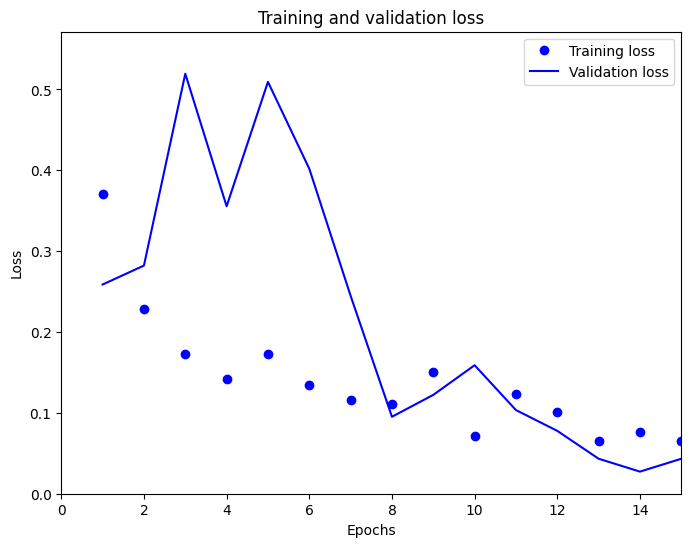

In [4]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.axis([0, NUM_EPOCHS, 0, max(max(loss_values), max(val_loss_values)) + 0.1*max(max(loss_values), max(val_loss_values))])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(LOSS_OUTPUT_DIR)
plt.show()

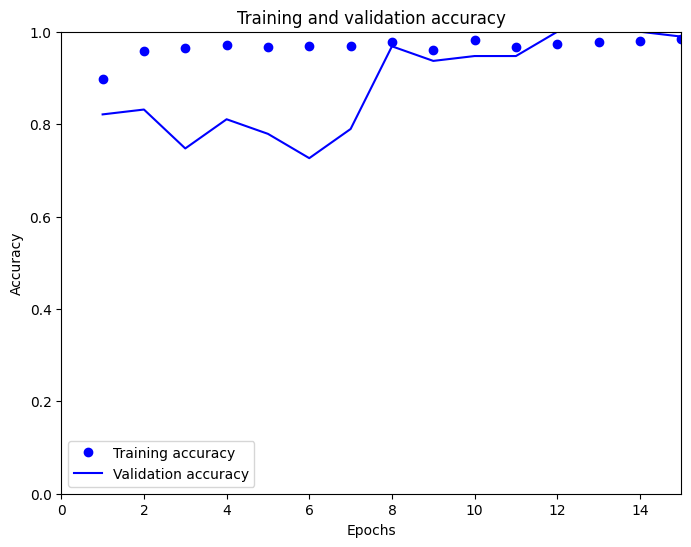

In [5]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.axis([0, NUM_EPOCHS, 0, 1])
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(ACC_OUTPUT_DIR)
plt.show()

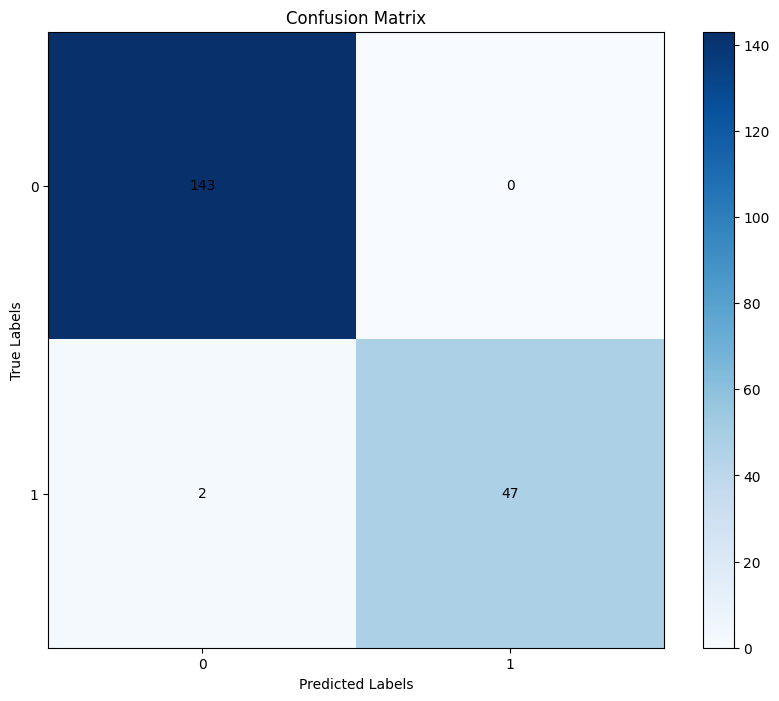

In [6]:
# compute the confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels
y_true = []
y_pred = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    y_pred.extend( np.argmax( model.predict(images) , axis = - 1) )

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(N_CLASSES))
plt.yticks(np.arange(N_CLASSES))
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')
plt.savefig(CONF_OUTPUT_DIR)
plt.show()

In [7]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(test_dataset)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

12/12 [==============================] - 3s 127ms/step - loss: 0.0284 - accuracy: 0.9948
Final loss: 0.028374, final accuracy: 0.994792


Saving the model

In [8]:
model.save(MODEL_OUTPUT_DIR)